In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt

from collections import Counter


from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

C:\Users\suhit\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\suhit\Miniconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def process_data_for_labels(ticker):
    hm_days = 7
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1,hm_days+1):
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
        
    df.fillna(0, inplace=True)
    return tickers, df


Now we will create our label.  If the price rises more than 2% in the next 7 days, we're going to say that's a buy. If it drops more than 2% in the next 7 days, that's a sell. If it doesn't do either of those, then it's not moving enough, and we're going to just hold whatever our position is.


In [3]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0


In [4]:


def extract_featuresets(ticker) :
    tickers, df = process_data_for_labels(ticker)
    
    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                             df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)] ))
    #map() function returns a list of the results after applying 
    #the given function to each item of a given iterable (list, tuple etc.)
    #map(fun, iter)
    
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:', Counter(str_vals))
    
    #CLean up ur data
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    """we probably have some infinite data, especially
       if we did a percent change from 0 to anything. 
       We're going to convert infinite values to NaNs, 
       then we're going to drop NaNs."""
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X,y,df



Data spread: Counter({'1': 1032, '-1': 833, '0': 375})


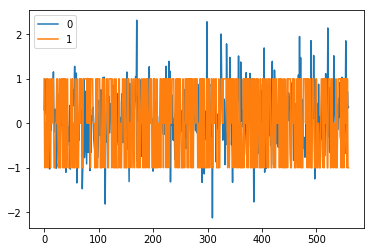

Accuracy: -0.42349263297309214
RMS Score: 1.0845241179352103
Predicted class counts: Counter({0.30111952871423336: 1, 1.0000720581324734: 1, 0.29310946298208873: 1, 0.366038334893614: 1, 0.1942363311274548: 1, 0.5374143409923461: 1, 0.2694108788828436: 1, 0.973450367670706: 1, 0.2556467502805659: 1, 0.5089570299694114: 1, -1.0276320927491478: 1, 0.4150475938107064: 1, 0.21431624280945372: 1, -0.16118190199875898: 1, 0.39927767822904087: 1, 0.315363891653739: 1, 0.669709424859396: 1, 1.1564826015286709: 1, -0.1955410112544539: 1, 0.03873081706833002: 1, 0.3180838603530766: 1, 0.04460869530309415: 1, -1.010395413970096: 1, -0.38841745627803514: 1, 0.9278761976927685: 1, -0.2697844292686184: 1, -0.9753589882174598: 1, -0.8423659676252108: 1, 0.6577808317012008: 1, -0.42374746094142984: 1, -0.22529780523997117: 1, 0.2764117605880606: 1, -0.05546305913506673: 1, 0.05637377544454057: 1, 0.2853410900278667: 1, -0.2811374976347289: 1, -0.2132395832409612: 1, 0.9946175782792092: 1, -0.702091637

-0.42349263297309214

In [18]:
%matplotlib inline
def do_ml_LR(ticker):
    X, y, df = extract_featuresets(ticker)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    clf = linear_model.LinearRegression()
    
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    pd.DataFrame(predictions,y_test).to_csv('LR.csv')
    
   
    plt.plot(predictions, label= 0)
    plt.plot(y_test, label= 1)
    plt.legend()
    plt.show()
    
    accuracy = clf.score(X_test, y_test)
    
    
    print('Accuracy:', accuracy)
    print('RMS Score:', np.sqrt(mean_squared_error(y_test,predictions)))
   
    print('Predicted class counts:', Counter(predictions))
  
    print()
    print()
    return accuracy
do_ml_LR('AAPL')

Data spread: Counter({'1': 1032, '-1': 833, '0': 375})


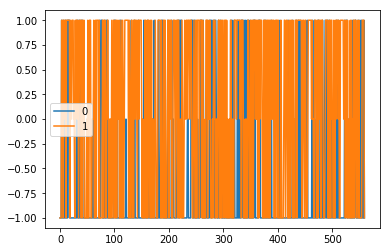

Accuracy: 0.35714285714285715
RMS Score: 1.407885953173359
Predicted class counts: Counter({-1: 425, 1: 107, 0: 28})




0.35714285714285715

In [13]:

%matplotlib inline
def do_ml_LR(ticker):
    X, y, df = extract_featuresets(ticker)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    clf = neighbors.KNeighborsClassifier()
    
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    pd.DataFrame(predictions,y_test).to_csv('KNN.csv')
    
   
    plt.plot(predictions, label= 0)
    plt.plot(y_test, label= 1)
    plt.legend()
    plt.show()
    
    accuracy = clf.score(X_test, y_test)
    
    
    print('Accuracy:', accuracy)
    print('RMS Score:', np.sqrt(mean_squared_error(y_test,predictions)))
   
    print('Predicted class counts:', Counter(predictions))
  
    print()
    print()
    return accuracy
do_ml_LR('AAPL')

Data spread: Counter({'1': 1032, '-1': 833, '0': 375})


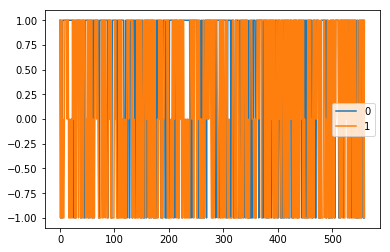

Accuracy: 0.44107142857142856
RMS Score: 1.324224840641282
Predicted class counts: Counter({1: 407, -1: 153})




0.44107142857142856

In [12]:
%matplotlib inline
def do_ml_LR(ticker):
    X, y, df = extract_featuresets(ticker)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    clf = svm.LinearSVC()
    
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    pd.DataFrame(predictions,y_test).to_csv('LSVM.csv')
    
   
    plt.plot(predictions, label= 0)
    plt.plot(y_test, label= 1)
    plt.legend()
    plt.show()
    
    accuracy = clf.score(X_test, y_test)
    
    
    print('Accuracy:', accuracy)
    print('RMS Score:', np.sqrt(mean_squared_error(y_test,predictions)))
   
    print('Predicted class counts:', Counter(predictions))
  
    print()
    print()
    return accuracy
do_ml_LR('AAPL')

Data spread: Counter({'1': 1032, '-1': 833, '0': 375})


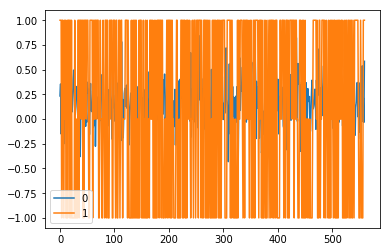

Accuracy: -0.0392725497139228
RMS Score: 0.9219255133128663
Predicted class counts: Counter({0.2335906478133738: 1, 0.35530692880709946: 1, -0.15068032475469634: 1, 0.25694037636232064: 1, 0.0533478784768205: 1, 0.2422026470465245: 1, -0.0470360790093132: 1, -0.17263435366122276: 1, -0.24733780939989825: 1, 0.46044853954318193: 1, 0.2620675150651164: 1, -0.007752617521654015: 1, 0.5187404963163222: 1, 0.008054083487508745: 1, 0.05505185333208093: 1, 0.23798559513550738: 1, 0.4728975646335404: 1, 0.00018258257643669062: 1, -0.04531535923264629: 1, 0.03709025408668315: 1, 0.47895828106323096: 1, 0.20225026215028236: 1, 0.07258973602271257: 1, 0.15000730879759872: 1, 0.40559841734795554: 1, 0.49530436487295226: 1, 0.32148490125724605: 1, 0.16791705677250607: 1, 0.04424824251336368: 1, 0.12739636347250968: 1, 0.329526149087936: 1, 0.23034471212419136: 1, 0.21313655539064127: 1, -0.03430685899680916: 1, 0.5792916697579753: 1, 0.49540916198865925: 1, -0.0753662696928139: 1, -0.37902576551110

-0.0392725497139228

In [17]:
%matplotlib inline
def do_ml_LR(ticker):
    X, y, df = extract_featuresets(ticker)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    clf = svm.SVR(kernel='linear')
    
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    pd.DataFrame(predictions,y_test).to_csv('LSVC.csv')
    
   
    plt.plot(predictions, label= 0)
    plt.plot(y_test, label= 1)
    plt.legend()
    plt.show()
    
    accuracy = clf.score(X_test, y_test)
    
    
    print('Accuracy:', accuracy)
    print('RMS Score:', np.sqrt(mean_squared_error(y_test,predictions)))
   
    print('Predicted class counts:', Counter(predictions))
  
    print()
    print()
    return accuracy
do_ml_LR('AAPL')

Data spread: Counter({'1': 1032, '-1': 833, '0': 375})


C:\Users\suhit\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\suhit\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


<IPython.core.display.Javascript object>


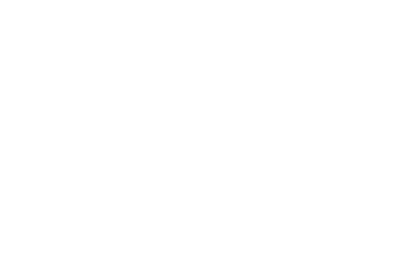

Accuracy: 0.37142857142857144
RMS Score: 1.4085199932654742
Predicted class counts: Counter({1: 292, -1: 258, 0: 10})




0.37142857142857144

<IPython.core.display.Javascript object>


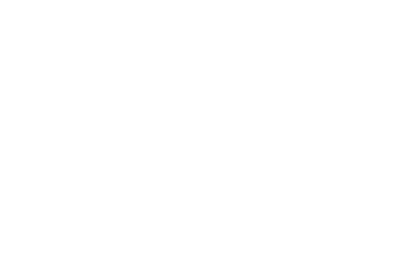

In [21]:
%matplotlib notebook
def do_ml(ticker):
    X, y, df = extract_featuresets(ticker)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    clf = VotingClassifier([('Linear Support Vector', svm.LinearSVC()),
                            ('KNN', neighbors.KNeighborsClassifier()),
                            ('Random Forest', RandomForestClassifier())])
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    pd.DataFrame(predictions,y_test).to_csv('VC.csv')
    accuracy = clf.score(X_test, y_test)
    
    plt.plot(predictions, label= 0)
    plt.plot(y_test, label= 1)
    plt.legend()
    plt.show()
    
    
    print('Accuracy:', accuracy)
    print('RMS Score:', np.sqrt(mean_squared_error(y_test,predictions)))
    
   
    print('Predicted class counts:', Counter(predictions))
    print()
    print()
    return accuracy

do_ml('AAPL')





In [7]:
do_ml('XOM')

Data spread: Counter({'0': 871, '1': 730, '-1': 639})


C:\Users\suhit\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.37142857142857144
Predicted class counts: Counter({0: 285, -1: 188, 1: 87})




C:\Users\suhit\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.37142857142857144

In [8]:
do_ml('MMM')

Data spread: Counter({'0': 860, '1': 816, '-1': 564})


C:\Users\suhit\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.36964285714285716
Predicted class counts: Counter({0: 343, -1: 114, 1: 103})




C:\Users\suhit\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.36964285714285716

In [6]:
do_ml('AAPL')

Data spread: Counter({'1': 1032, '-1': 833, '0': 375})


C:\Users\suhit\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.42678571428571427
Predicted class counts: Counter({-1: 285, 1: 267, 0: 8})




C:\Users\suhit\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.42678571428571427